Proof-of-Concept for Collaborative Filtering

In [1]:
# Install libraries locally
!pip3 install pandas
!pip3 install -U scikit-learn scipy matplotlib
!pip3 install scikit-learn

     |████████████████████████████████| 10.2 MB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 37.3 MB 28.2 MB/s eta 0:00:01
     |████████████████████████████████| 7.6 MB 143 kB/s eta 0:00:01
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
     |████████████████████████████████| 20.6 MB 6.5 MB/s eta 0:00:01
  Using cached importlib_resources-6.1.1-py3-none-any.whl (33 kB)
     |████████████████████████████████| 257 kB 8.4 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.1
    Uninstalling scipy-1.7.1:
      Successfully uninstalled scipy-1.7.1
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import pickle as pkl

In [4]:
original_df = pd.read_csv("./RAW_recipes.csv")
df = original_df.copy()
df['description'] = df['description'].fillna('')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     231637 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


In [6]:
# sort by date of submission and take only the first 1000 recipes for speed of model creation
df.sort_values('submitted', inplace=True, ascending=False)
df = df.iloc[:10000].reset_index(drop=True)
df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,mini buffalo chicken cheesesteaks,537716,40,2001975627,2018-12-04,"['60-minutes-or-less', 'time-to-make', 'course...","[407.9, 34.0, 21.0, 49.0, 28.0, 64.0, 12.0]",12,['heat 1 tablespoon of olive oil in a skillet ...,these party-style chicken cheesesteaks are fla...,"['olive oil', 'green bell pepper', 'yellow oni...",13
1,nutcracker peppermint red velvet cake pops,537671,135,2002198506,2018-11-28,"['time-to-make', 'course', 'preparation', 'occ...","[207.9, 12.0, 93.0, 10.0, 6.0, 8.0, 10.0]",54,"['before you begin , you will need to gather t...",rich red velvet cake combines with cool pepper...,"[""devil's food cake mix"", 'eggs', 'buttermilk'...",12
2,moist gingerbread cake,537543,55,2001201872,2018-11-16,"['60-minutes-or-less', 'time-to-make', 'course...","[1617.0, 104.0, 213.0, 8.0, 40.0, 203.0, 80.0]",8,"['preheat the oven to 350&deg', 'f grease a lo...",a slightly sticky loaf cake flavoured with gin...,"['unsalted butter', 'applesauce', 'egg', 'unsu...",10
3,5 ingredient salted caramel crumble bars,537485,45,2000378667,2018-11-12,"['60-minutes-or-less', 'time-to-make', 'course...","[52.8, 3.0, 0.0, 4.0, 1.0, 1.0, 2.0]",21,"['1', 'heat oven to 350f spray 8-inch square p...",delicious,"['pillsbury sugar cookie dough', 'caramel topp...",5
4,bailey s chocotini,537459,10,400708,2018-11-10,"['15-minutes-or-less', 'time-to-make', 'course...","[220.7, 15.0, 49.0, 2.0, 3.0, 30.0, 4.0]",5,"['to layer: add chocolate liqueur to glass', '...",a recipe that recipe complements the cocoa in ...,"['baileys irish cream', 'chocolate liqueur', '...",3


mini buffalo chicken cheesesteaks
nutcracker peppermint red velvet cake pops
moist gingerbread cake
5 ingredient salted caramel crumble bars
bailey s chocotini
garlic and herb mashed potatoes
red wine braised short ribs with fingerlings potatoes
one pan no peek chicken and rice
copycat chick fil a spicy deluxe chicken sandwich
campbell s mini green bean casseroles
pumpkin spice granola
carrot apple zucchini bread
poinsettia pull apart cookies
rapid rise skillet yeast rolls
vampire s kiss cake
baked shrimp and orzo with chickpeas  lemon  and dill
french onion baked potato soup
instant pot turkey chili
thanksgiving turkey meatloaf
garlic baked brie spider
slow cooker soy braised chicken
pretzel beer cheese stuffing
chicken meatball tikka masala
cheesy buffalo chicken skulls
spicy red pepper jelly
pumpkin spice latte cake
better than del taco chicken soft tacos
sheet pan turkey caprese meatballs with rosemary smashed potatoe
sheet pan shrimp scampi
lemon pom pom cake
grilled cajun green b

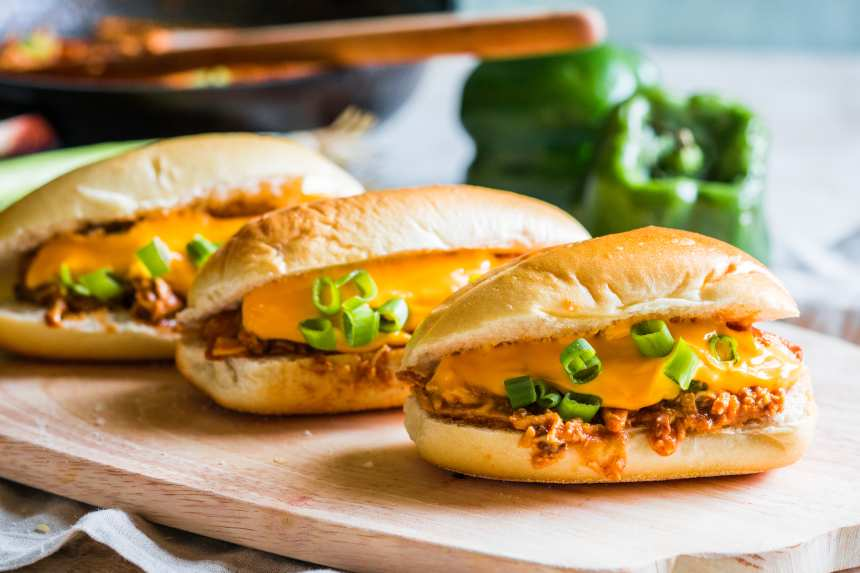

Success


In [21]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from IPython.display import display, Image

name = df.iloc[0]['name'].replace(' ', '-')
id = df.iloc[0]['id']
testurl = f"https://www.food.com/recipe/{name}-{id}"

def image_checker(url):
    resp = requests.get(url)

    if resp.status_code == 200:
        parsedText = BeautifulSoup(resp.text, 'html.parser')
        image_tag = parsedText.find('img', class_= 'only-desktop svelte-kb6fq')
        if image_tag:
            image_url = image_tag['src']
            abs_image_url = urljoin(url, image_url)

            image_resp = requests.get(abs_image_url)

            if image_resp.status_code == 200:
                # display(Image(image_resp.content))
                # print('Success')
                return True
            else:
                # print('Cannot download image')
                return False
        else:
            # print("No image with specified class")
            return False
    else:
        # print("Failed to retrieve webpage")
        return False



for i in df.itertuples():
    name = i.name.replace(' ', '-')
    id = i.id
    testurl = f"https://www.food.com/recipe/{name}-{id}"
    image_checker(testurl)


## Content Filtering

In [6]:
# Create a TfidfVectorizer and Remove stopwords
tfidf1 = TfidfVectorizer(stop_words='english')
# Fit and transform the data to a tfidf matrix
tfidf_matrix1 = tfidf1.fit_transform(df['ingredients'])
# Print the shape of the tfidf_matrix
tfidf_matrix1.shape

(10000, 2114)

In [7]:
# Compute the cosine similarity between each meal's ingredients
cosine_sim1 = linear_kernel(tfidf_matrix1, tfidf_matrix1)

In [8]:
# Create a TfidfVectorizer and Remove stopwords
tfidf2 = TfidfVectorizer(stop_words='english')
# Fit and transform the data to a tfidf matrix
tfidf_matrix2 = tfidf2.fit_transform(df['name'])
# Print the shape of the tfidf_matrix
tfidf_matrix2.shape

(10000, 5593)

In [9]:
# Compute the cosine similarity between each meal's name
cosine_sim2 = linear_kernel(tfidf_matrix2, tfidf_matrix2)

In [10]:
# Combine the two matrices for a combined output (weighing the ingredients in the dish more heavily than the name of it)
cosine_sim3= cosine_sim1*0.7 + cosine_sim2*0.3

In [11]:
indices = pd.Series(df.index, index=df['name']).drop_duplicates()
indices

name
mini buffalo chicken cheesesteaks                                  0
nutcracker peppermint red velvet cake pops                         1
moist gingerbread cake                                             2
5 ingredient salted caramel crumble bars                           3
bailey s chocotini                                                 4
                                                                ... 
momma jan s good for what ails ya chicken soup                  9995
botswanan chicken groundnut stew                                9996
how to peel a head of garlic in less than 10 seconds            9997
mushroom and sausage bake                                       9998
bacon   goat cheese potatoes with sundried tomato sour cream    9999
Length: 10000, dtype: int64

In [12]:
indices_to_name = {}
for i in indices:
    indices_to_name[i] = df['name'].iloc[i]
indices_to_name[0]

'mini buffalo chicken cheesesteaks'

In [13]:




def get_recommendations(title, cosine_sim=cosine_sim3, num_recommend = 10):
    idx = indices[title]
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores of the 10 most similar movies
    top_similar = sim_scores[1:num_recommend+1]

    # Get the recipe indices and corresponding recipe similarity score
    recipe_indices = [i[0] for i in top_similar]
    recipe_similarity_scores = [i[1] for i in top_similar]

    recommendations_df = df['name'].iloc[recipe_indices].to_frame().reset_index()
    recommendations_df['score'] = recipe_similarity_scores

# Return the top 10 most similar recipes
    return recommendations_df

In [14]:
get_recommendations('moist gingerbread cake')  

,index,name,score
0,5876,gluten free gingerbread cake,0.526619
1,6013,gingerbread spice blend,0.425092
2,6005,tartine s soft glazed gingerbread,0.413173
3,2015,gingerbread smoothie,0.401514
4,2683,pumpkin gingerbread w caramel sauce,0.400659
5,4662,homemade brown sugar,0.337018
6,1286,ginger snaps,0.327362
7,5912,crunchy gingerbread cookies,0.324023
8,7104,applesauce apple butter,0.320325
9,7482,cardamom ginger crunch,0.317083


## Pickle Creation

In [15]:
type(cosine_sim3)

numpy.ndarray

In [16]:
# Store cosine similarities pickle
with open('../pickles/cosine-similarities.pkl', 'wb') as f:
    pkl.dump(cosine_sim3, f)

In [17]:
# Store cosine indices pickle
with open('../pickles/indicies.pkl', 'wb') as f:
    pkl.dump(indices, f)

In [18]:
# Store cosine indices pickle
with open('../pickles/indicies-to-name.pkl', 'wb') as f:
    pkl.dump(indices_to_name, f)

## Interaction Data

In [19]:
# import interaction data
original_interaction_df = pd.read_csv("RAW_interactions.csv")
interaction_df = original_interaction_df.copy()

In [20]:
# create list of all recipe ids
recipe_id_list = df["id"].tolist()

In [21]:
# subselect only those interactions that are of recipes in the list created above
interaction_df = interaction_df[interaction_df['recipe_id'].isin(recipe_id_list)]
interaction_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24432 entries, 119 to 1132340
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    24432 non-null  int64 
 1   recipe_id  24432 non-null  int64 
 2   date       24432 non-null  object
 3   rating     24432 non-null  int64 
 4   review     24414 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [22]:
# group reviews by the recipe they refer to, sorted from most reviewed to least
aggregated_df = interaction_df.groupby(["recipe_id"]).size().sort_values(ascending=False)
aggregated_df = aggregated_df.to_frame().reset_index().rename(columns={0: "count"})
aggregated_df.head()

,recipe_id,count
0,486261,217
1,486496,202
2,486641,179
3,497021,127
4,495271,90


In [23]:
# merge the aggregated dataframe with recipes to get the associated name of the recipe
combined_df = pd.merge(left=df[['id', 'name']], right=aggregated_df, left_on='id', right_on='recipe_id').sort_values(by='count',ascending=False)
combined_df.drop(['id'], axis=1, inplace=True)
combined_df.head()

,name,recipe_id,count
7053,mexican stack up rsc,486261,217
7003,bacon lattice tomato muffins rsc,486496,202
6967,moist delicious banana nut bread,486641,179
4941,mile high cabbage pie 5fix,497021,127
5256,spinach and cheese stuffed chicken breast rsc,495271,90


In [24]:
# isolate to only the top 50 most reviewed recipes 
top_50_df = combined_df.iloc[0:50]
top_50_df.reset_index(inplace=True, drop=True)
top_50_df.to_csv('top50recipes.csv')

## Apriori Dataset Creation

In [25]:
# sort reviews by the user_id then the date the review was published (earliest to latest)
apriori_prep_df = interaction_df
apriori_prep_df.sort_values(by=['user_id', 'date'], inplace=True)
apriori_prep_df.reset_index(drop=True, inplace=True)
apriori_prep_df.head()

,user_id,recipe_id,date,rating,review
0,1535,494972,2013-05-07,4,"Nice comfort food for a chilly, rainy evening...."
1,1535,495227,2014-03-01,5,Fantastic!! I can&#039;t believe no one has tr...
2,1535,516391,2014-10-14,5,My family LOVED these. I like the fact that th...
3,1535,476476,2014-12-09,4,Needed a last minute dessert and had a cake mi...
4,1535,499705,2015-05-21,5,Very lemony indeed!! They got rave reviews fro...


In [26]:
# dictionary of the recipe id and corresponding ratings a user gave 
apriori_prep_df['rating_dict'] = apriori_prep_df.apply(lambda row: {'recipe_id': row['recipe_id'], 'rating': row['rating']}, axis=1)
apriori_prep_df.head()

,user_id,recipe_id,date,rating,review,rating_dict
0,1535,494972,2013-05-07,4,"Nice comfort food for a chilly, rainy evening....","{'recipe_id': 494972, 'rating': 4}"
1,1535,495227,2014-03-01,5,Fantastic!! I can&#039;t believe no one has tr...,"{'recipe_id': 495227, 'rating': 5}"
2,1535,516391,2014-10-14,5,My family LOVED these. I like the fact that th...,"{'recipe_id': 516391, 'rating': 5}"
3,1535,476476,2014-12-09,4,Needed a last minute dessert and had a cake mi...,"{'recipe_id': 476476, 'rating': 4}"
4,1535,499705,2015-05-21,5,Very lemony indeed!! They got rave reviews fro...,"{'recipe_id': 499705, 'rating': 5}"


In [27]:
# create a column containing all the recipe/ratings a user has ever given
apriori_final_df = apriori_prep_df.groupby('user_id')['rating_dict'].apply(list)
apriori_final_df = apriori_final_df.to_frame().reset_index()
apriori_final_df.head()

,user_id,rating_dict
0,1535,"[{'recipe_id': 494972, 'rating': 4}, {'recipe_..."
1,1676,"[{'recipe_id': 490418, 'rating': 5}]"
2,4291,"[{'recipe_id': 476060, 'rating': 4}, {'recipe_..."
3,4439,"[{'recipe_id': 477675, 'rating': 5}, {'recipe_..."
4,4740,"[{'recipe_id': 500256, 'rating': 2}, {'recipe_..."


In [28]:
# save to csv for collaborative filter training
apriori_final_df.to_csv('apriori_df.csv')